## Table of Contents

* [Import Libraries](#import-libraries)
* [Import Clean Train and Test Data with Dummies](#import-clean-train-and-test-data-with-dummies)
* [Exploratory Data Analysis (EDA) and Visualizations](#exploratory-data-analysis-(eda)-and-visualizations)
    * [Heatmaps](#heatmaps)
    * [Histogram and Pairplots](#histogram-and-pairplots)
* [TTS and Fit Model](#tts-and-fit-model)
    * [Model Prep](#model-prep)
    * [LINE Assumptions](#line-assumptions)
* [Score Model](#score-model)
    * [Statsmodel Library](#statsmodel-library)
* [Ridge and LASSO Model](#ridge-and-lasso-model)
    * [Polynomial Features](#polynomial-features)
    * [OLS](#ols)
    * [RidgeCV](#ridgecv)
    * [LASSOCV](#lassocv)
* [Visualizations](#visualizations)

# Import Libraries

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

# Suppress ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Import Clean Train and Test Data with Dummies

In [45]:
# load Training Data
train = pd.read_csv('../clean_datasets/finish_clean_training_dummified.csv')

# Load Testing Data
test = pd.read_csv('../clean_datasets/finish_clean_testing_dummified.csv')

In [46]:
train.shape

(2051, 207)

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Columns: 207 entries, id to sale_type_WD 
dtypes: float64(9), int64(194), object(4)
memory usage: 3.2+ MB


In [48]:
train.head()

,id,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,year_built,year_remod/add,...,misc_feature_Shed,misc_feature_TenC,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD
0,109,0.0,13517,2,3,Gtl,6,8,1976,2005,...,0,0,0,0,0,0,0,0,0,1
1,544,43.0,11492,2,3,Gtl,7,5,1996,1997,...,0,0,0,0,0,0,0,0,0,1
2,153,68.0,7922,3,3,Gtl,5,7,1953,2007,...,0,0,0,0,0,0,0,0,0,1
3,318,73.0,9802,3,3,Gtl,5,5,2006,2007,...,0,0,0,0,0,0,0,0,0,1
4,255,82.0,14235,2,3,Gtl,6,8,1900,1993,...,0,0,0,0,0,0,0,0,0,1


In [49]:
test.shape

(878, 195)

# Exploratory Data Analysis (EDA) and Visualizations

## Heatmaps

C:\Users\Crypt\AppData\Local\Temp\ipykernel_19028\2703748892.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = abs(train.corr()[['saleprice']])


Correlations below threshold:
                      saleprice
exterior_1st_WdShing   0.048866
3ssn_porch             0.048732
condition_2_Feedr      0.048455
exterior_2nd_Brk Cmn   0.047893
misc_feature_Shed      0.047419
...                         ...
roof_matl_Tar&Grv      0.007018
sale_type_CWD          0.004563
neighborhood_Greens    0.003476
foundation_Wood        0.003044
condition_2_RRAe       0.002378

[77 rows x 1 columns]


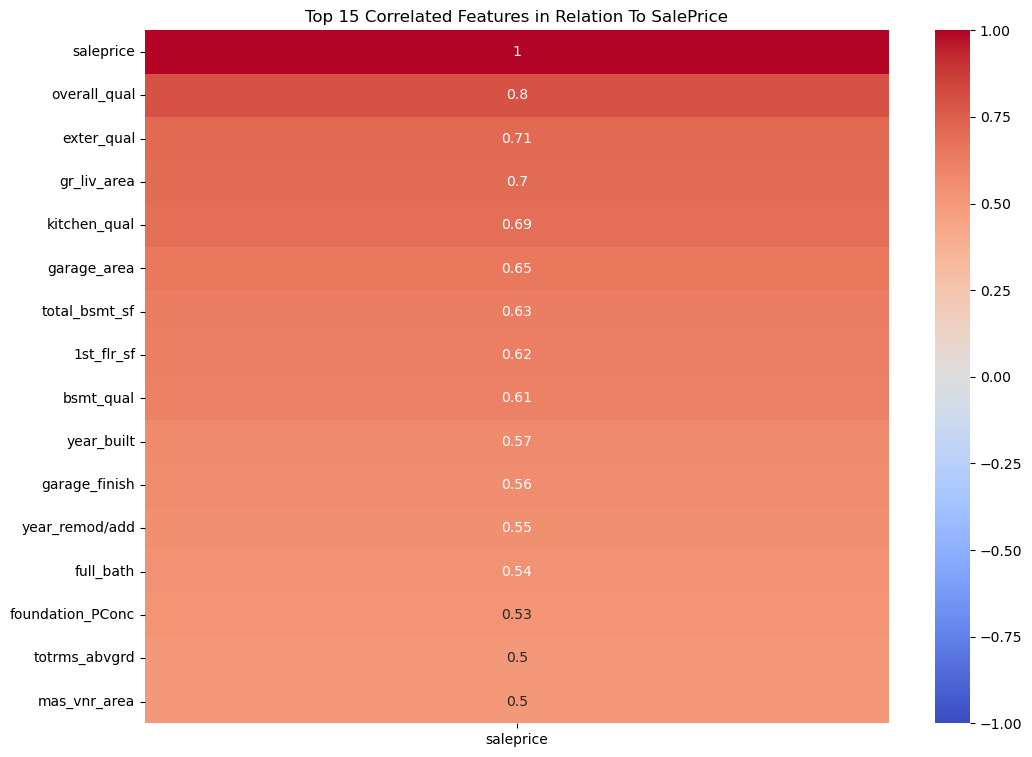

In [50]:
# Because there are over 200 columns, I will be looking at the top 15 correlations with a threshold of 5%

# Threshold for correlation for 'saleprice'
threshold = 0.05

# Top correlated with 'saleprice'
top_n = 16

# Absolute correlations with 'saleprice'
corr_matrix = abs(train.corr()[['saleprice']])
sorted_corr = corr_matrix.sort_values('saleprice', ascending=False)

# Filter the correlations that are below threshold
below_threshold_corr = sorted_corr.loc[sorted_corr['saleprice'] < threshold]

# Top correlated features
top_n_corr = sorted_corr.iloc[:top_n]

# Plot heatmap for top correlated features
plt.figure(figsize=(12, 9))
sns.heatmap(top_n_corr,
            annot=True,
            vmin=-1,
            vmax=1,
            cmap='coolwarm');
plt.title('Top 15 Correlated Features in Relation To SalePrice')

# Print the Correlations that are below the threshold
print("Correlations below threshold:")
print(below_threshold_corr)

- **Independent variables with strongest correlation:** overall_qual (0.8), exter_qual(0.71), gr_liv_area (0.7), kitchen_qual(0.69), garage_area (0.65), total_bsmt_sf (0.63), 1st_flr_sf (0.62), bsmt_qual (0.61), year_built (0.57), garage_finish (0.56), year_remod/add (0.55), full_bath (0.54), foundation_PConc (0.53), totrms_abvgrd (0.5), mas_vnr_area (0.5)

In [51]:
train_columns = train[[
    'overall_qual',
    'exter_qual',
    'gr_liv_area',
    'kitchen_qual',
    'garage_area',
    'total_bsmt_sf',
    '1st_flr_sf',
    'bsmt_qual',
    'year_built',
    'garage_finish',
    'year_remod/add',
    'full_bath',
    'foundation_PConc',
    'totrms_abvgrd',
    'mas_vnr_area',
    'saleprice',
]]

In [52]:
# Combine Interactive Variables

# Train
# Overall/Exterior quality of house
train_columns['overall_qual_exter_qual'] = train_columns['overall_qual']*train_columns['exter_qual']

# Above-ground living area and size of garage
train_columns['gr_liv_area_garage_area'] = train_columns['gr_liv_area']*train_columns['garage_area']

# Total basement area and first floor area
train_columns['total_bsmt_sf_1st_flr_sf'] = train_columns['total_bsmt_sf']*train_columns['1st_flr_sf']

# Basement quality and finish of garage
train_columns['bsmt_qual_garage_finish'] = train_columns['bsmt_qual']*train_columns['garage_finish']

# Year house was built and last remodeled
train_columns['year_built_year_remod/add'] = train_columns['year_built']*train_columns['year_remod/add']

# Test
# Overall/Exterior quality of house
test['overall_qual_exter_qual'] = test['overall_qual']*test['exter_qual']

# Above-ground living area and size of garage
test['gr_liv_area_garage_area'] = test['gr_liv_area']*test['garage_area']

# Total basement area and first floor area
test['total_bsmt_sf_1st_flr_sf'] = test['total_bsmt_sf']*test['1st_flr_sf']

# Basement quality and finish of garage
test['bsmt_qual_garage_finish'] = test['bsmt_qual']*test['garage_finish']

# Year house was built and last remodeled
test['year_built_year_remod/add'] = test['year_built']*test['year_remod/add']

C:\Users\Crypt\AppData\Local\Temp\ipykernel_19028\829777699.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_columns['overall_qual_exter_qual'] = train_columns['overall_qual']*train_columns['exter_qual']
C:\Users\Crypt\AppData\Local\Temp\ipykernel_19028\829777699.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_columns['gr_liv_area_garage_area'] = train_columns['gr_liv_area']*train_columns['garage_area']
C:\Users\Crypt\AppData\Local\Temp\ipykernel_19028\829777699.py:11: SettingWithCopyWarn

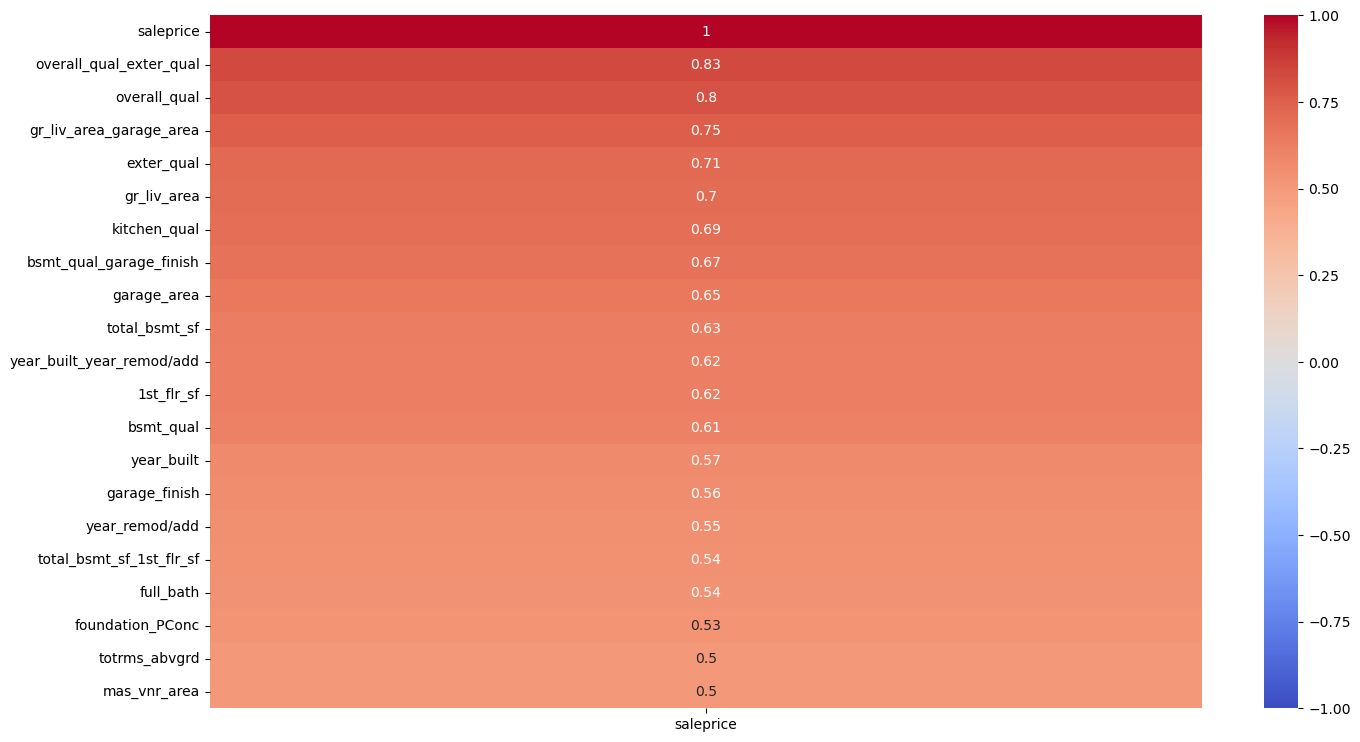

In [53]:
# Generate new heatmap with interaction terms
plt.figure(figsize=(16,9))
sns.heatmap(train_columns.corr()[['saleprice']].sort_values(by='saleprice', ascending=False),
            annot=True,
            vmin=-1,
            vmax=1,
            cmap='coolwarm',)
plt.savefig('correlation_heatmap.png');

> New heatmap with interaction terms added

## Histogram and Pairplots

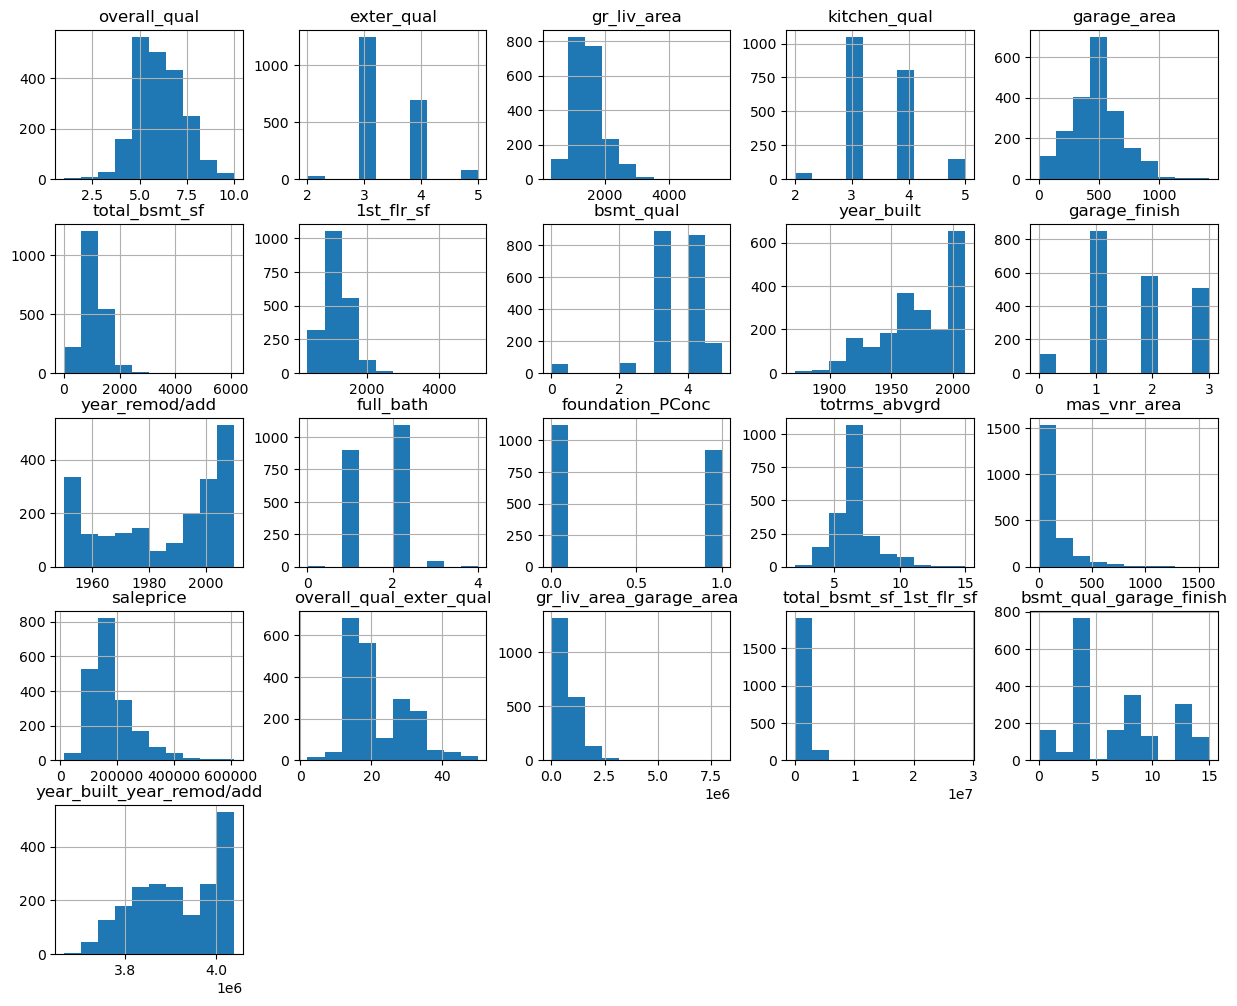

In [54]:
# Histogram created of each independent variable
train_columns.hist(figsize=(15, 12));

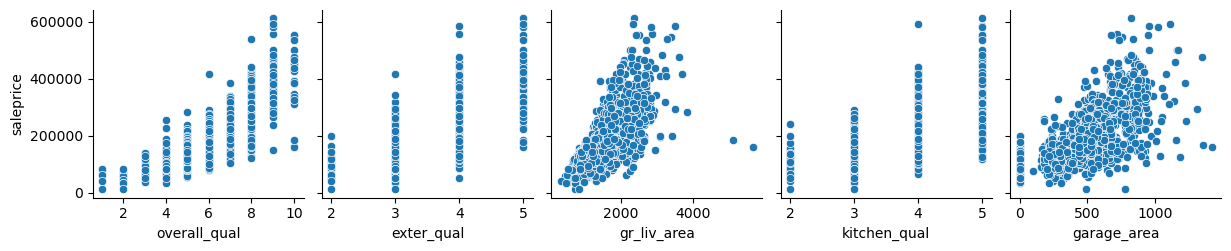

In [55]:
# Pairplots created to view the relationship between the independent variables and 'saleprice'
sns.pairplot(train_columns, x_vars=['overall_qual', 'exter_qual', 'gr_liv_area', 'kitchen_qual', 'garage_area'], y_vars=['saleprice']);

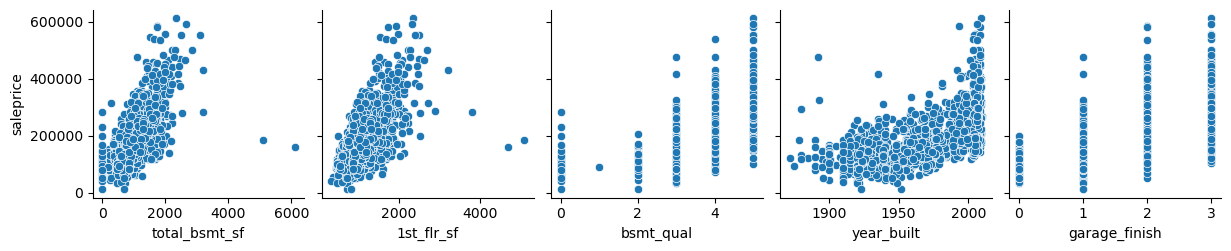

In [56]:
# Pairplots created to view the relationship between the independent variables and 'saleprice'
sns.pairplot(train_columns, x_vars=['total_bsmt_sf', '1st_flr_sf', 'bsmt_qual', 'year_built', 'garage_finish'], y_vars=['saleprice']);

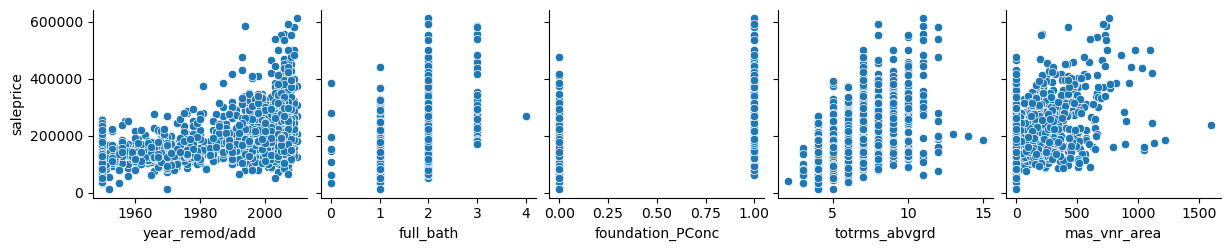

In [57]:
# Pairplots created to view the relationship between the independent variables and 'saleprice'
sns.pairplot(train_columns, x_vars=['year_remod/add', 'full_bath', 'foundation_PConc', 'totrms_abvgrd', 'mas_vnr_area'], y_vars=['saleprice']);

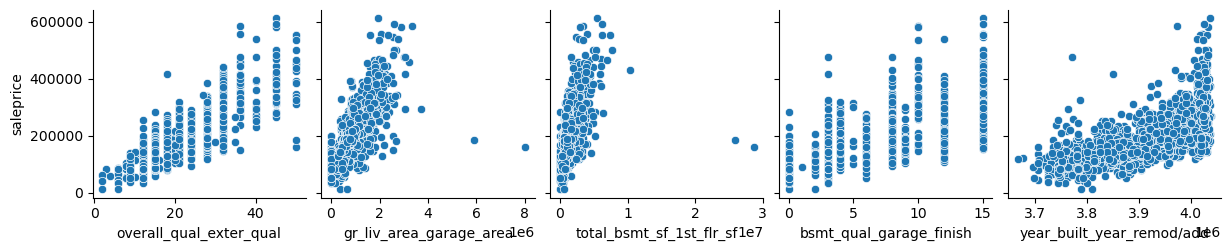

In [58]:
# Pairplots created to view the relationship between the independent variables and 'saleprice'
sns.pairplot(train_columns, x_vars=['overall_qual_exter_qual', 'gr_liv_area_garage_area', 'total_bsmt_sf_1st_flr_sf', 'bsmt_qual_garage_finish', 'year_built_year_remod/add'], y_vars=['saleprice']);

In [59]:
# Remove outliers from the pairplots

# Remove outlier from total_bsmt_sf to prevent heteroskedasticity
train_columns = train_columns[train_columns['total_bsmt_sf'] != 6110.0]
train_columns = train_columns[train_columns['total_bsmt_sf'] != 5095.0]

# Remove outlier from 1st_flr_sf to prevent heteroskedasticity
train_columns = train_columns[train_columns['1st_flr_sf'] != 5095]
train_columns = train_columns[train_columns['1st_flr_sf'] != 4692]

# Remove outlier from mas_vnr_area to prevent heteroskedasticity
train_columns = train_columns[train_columns['mas_vnr_area'] != 1600.0]

# Remove outlier from gr_liv_area_garage_area to prevent heteroskedasticity
train_columns = train_columns[train_columns['gr_liv_area_garage_area'] != 8000356.0]

# Remove outlier from total_bsmt_sf_1st_flr_sf to prevent heteroskedasticity
train_columns = train_columns[train_columns['total_bsmt_sf_1st_flr_sf'] != 28668120.0]
train_columns = train_columns[train_columns['total_bsmt_sf_1st_flr_sf'] != 25959025.0]
train_columns = train_columns[train_columns['total_bsmt_sf_1st_flr_sf'] != 10329600.0]

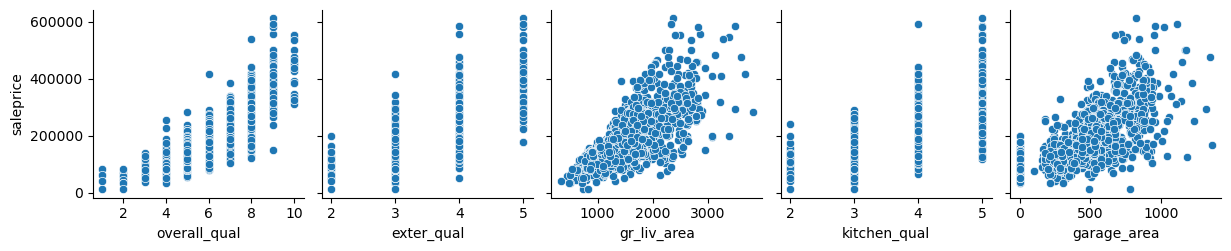

In [60]:
# Replot pairplots with outliers removed
sns.pairplot(train_columns, x_vars=['overall_qual', 'exter_qual', 'gr_liv_area', 'kitchen_qual', 'garage_area'], y_vars=['saleprice']);

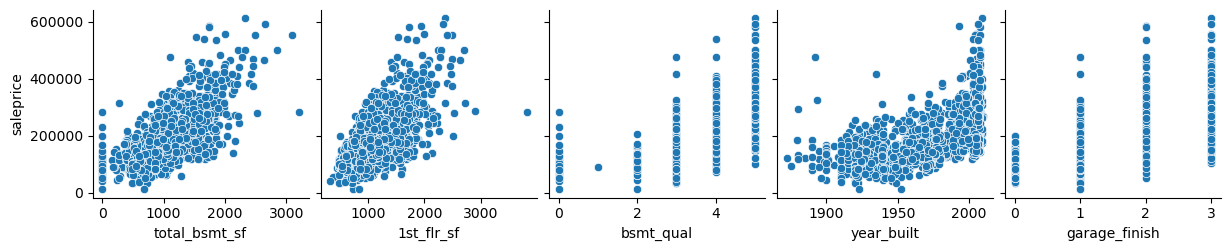

In [61]:
# Replot pairplots with outliers removed
sns.pairplot(train_columns, x_vars=['total_bsmt_sf', '1st_flr_sf', 'bsmt_qual', 'year_built', 'garage_finish'], y_vars=['saleprice']);

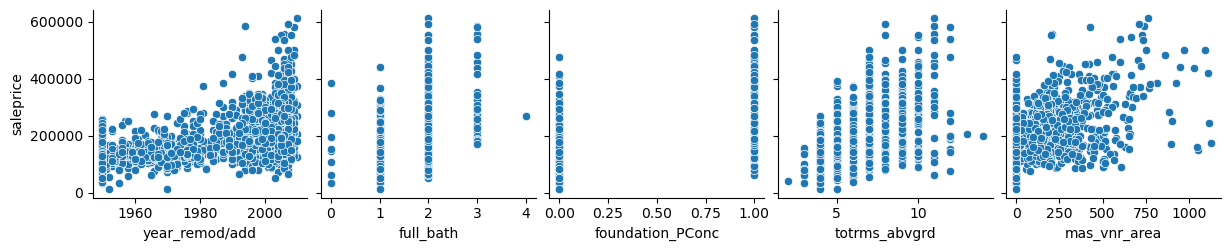

In [62]:
# Replot pairplots with outliers removed
sns.pairplot(train_columns, x_vars=['year_remod/add', 'full_bath', 'foundation_PConc', 'totrms_abvgrd', 'mas_vnr_area'], y_vars=['saleprice']);

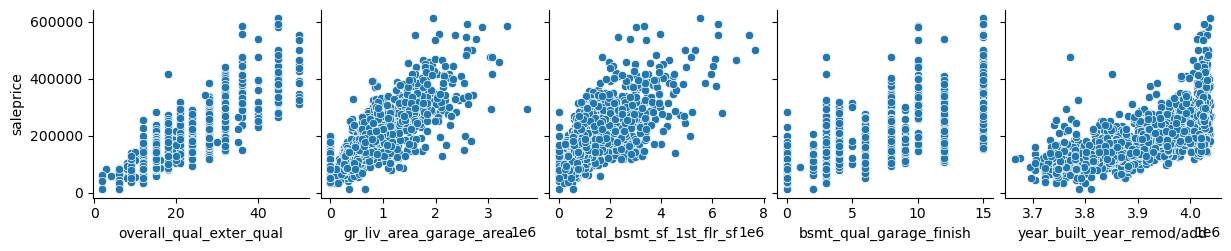

In [63]:
# Replot pairplots with outliers removed
sns.pairplot(train_columns, x_vars=['overall_qual_exter_qual', 'gr_liv_area_garage_area', 'total_bsmt_sf_1st_flr_sf', 'bsmt_qual_garage_finish', 'year_built_year_remod/add'], y_vars=['saleprice']);

# TTS and Fit Model

## Model Prep 

In [64]:
# Create X and y variables to fit on model
X = train_columns.drop('saleprice', axis=1)
y = train_columns['saleprice']

In [65]:
# Run TTS with random_state as year
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

In [66]:
# Scaling
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [67]:
# Instantiate and fit Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## LINE Assumptions

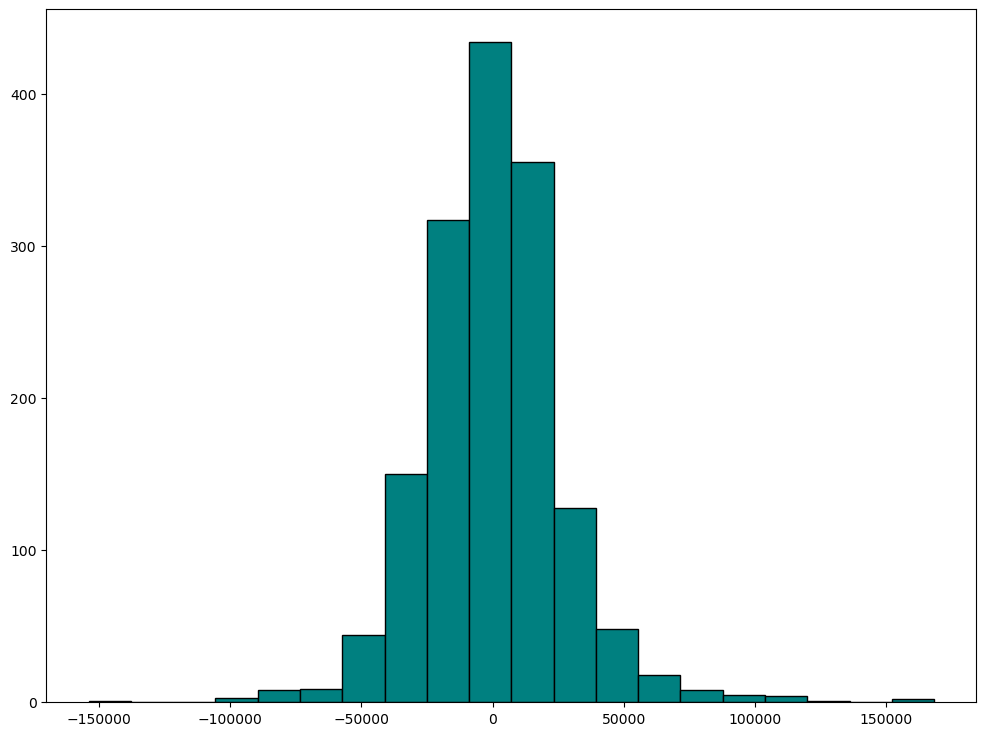

In [68]:
# N - Normality of errors
y_pred = lr.predict(X_train)
resids = y_train - y_pred

plt.figure(figsize=(12, 9))
plt.hist(resids, bins=20, color='teal', edgecolor='black')
plt.savefig('normal_dist.png');

> Histogram displays a normal distribution

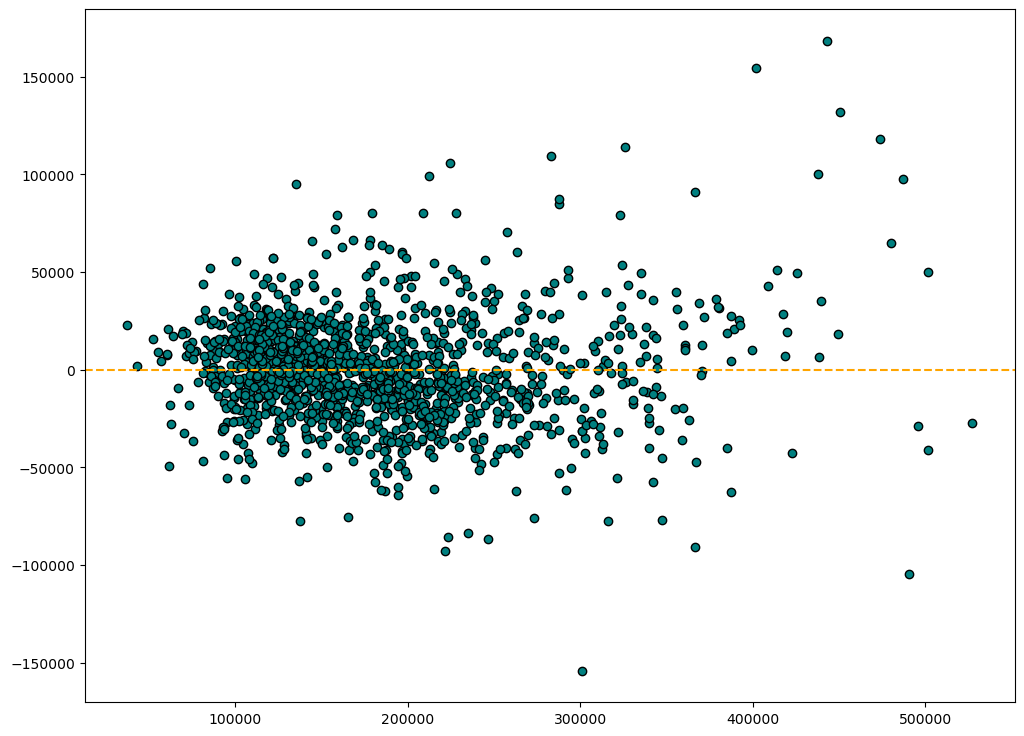

In [69]:
# E - Equal variance of errors
# Residual plot
plt.figure(figsize=(12,9))
plt.scatter(y_pred, resids, color='teal', edgecolor='black')
plt.axhline(0, color='orange', linestyle='--')
plt.savefig('homoscedastic.png');

> The equal variance of errors plot shows that it is homoskedastic. Dispersion of residuals is similar across the range of predicted values, assumptions of linear regression is met

# Score Model

In [70]:
# Using cross_val_score to find average R2 score with 10 folds
cross_val_score(lr, X_train, y_train, cv=10).mean()

0.8811233074351943

> Model correctly predicted the target variable for ~88% of the cases

In [71]:
# R2 score for train
print(f'Training R2 = {lr.score(X_train, y_train)}')

# R2 score for test
print(f'Testing R2 = {lr.score(X_test, y_test)}')

Training R2 = 0.8888868207775387
Testing R2 = 0.8668438245833612


> 84% of the variation in Sale Price can be explained by the independent variables

In [72]:
# Beta values for each independent variable
feature_names = ['overall_qual', 'exter_qual', 'gr_liv_area', 'kitchen_qual', 'garage_area',
                 'total_bsmt_sf', '1st_flr_sf', 'bsmt_qual', 'year_built', 'garage_finish',
                 'year_remod/add', 'full_bath', 'foundation_PConc', 'totrms_abvgrd',
                 'mas_vnr_area', 'saleprice', 'overall_qual_exter_qual',
                 'gr_liv_area_garage_area', 'total_bsmt_sf_1st_flr_sf',
                 'bsmt_qual_garage_finish']

independent_variable_coefs = pd.DataFrame({'Variable': feature_names, 'Coef': lr.coef_})
print(independent_variable_coefs)

                    Variable           Coef
0               overall_qual  -20611.010728
1                 exter_qual  -23820.127353
2                gr_liv_area    5263.058926
3               kitchen_qual    6119.401173
4                garage_area  -19204.534221
5              total_bsmt_sf     639.074292
6                 1st_flr_sf     520.036236
7                  bsmt_qual     435.672898
8                 year_built  298099.948923
9              garage_finish   -5913.174860
10            year_remod/add  204769.248007
11                 full_bath   -3803.850989
12          foundation_PConc    -164.138473
13             totrms_abvgrd      21.807537
14              mas_vnr_area    2813.524583
15                 saleprice   62069.854446
16   overall_qual_exter_qual   43809.629283
17   gr_liv_area_garage_area   13977.987125
18  total_bsmt_sf_1st_flr_sf   13789.213734
19   bsmt_qual_garage_finish -445571.159693


> Positive coefficients (> 0) represents an increase in the predicted saleprice, assuming all other factors remain constant. Negative coefficients represent a decrease in predicted saleprice

In [73]:
print(lr.intercept_)

180926.82540716729


> When the Sale Price of a home is zero, the price will be $12.03

## Statsmodel Library

In [74]:
X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     779.0
Date:                Mon, 07 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:08:03   Log-Likelihood:                -23779.
No. Observations:                2047   AIC:                         4.760e+04
Df Residuals:                    2026   BIC:                         4.772e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -1.329e+07   5.38e+06     -2.472      0.014   -2.38e+07   -2.75e+06
overall_qual               -1.67e+04   2731.918     -6.113      0.000   -2.21e+04   -1.13e+04
exter_qual                -4.695e+04   5560.585     -8.443      0.000   -5.79e+04    -3.6e+04
gr_liv_area                  21.8901      4.287      5.107      0.000      13.484      30.297
kitchen_qual               9860.5796   1473.042      6.694      0.000    6971.745    1.27e+04
garage_area                 -60.7058      9.317     -6.516      0.000     -78.978     -42.434
total_bsmt_sf                 0.2175      5.623      0.039      0.969     -10.810      11.245
1st_flr_sf                    1.2478      4.267      0.292      0.770      -7.121       9.617
bsmt_qual                   228.3304   1797.679      0.127      0.899   -3297.162    3753.823
year_built                 6629.2869   2765.054      2.398      0.017    1206.641    1.21e+04
garage_finish             -7567.3072   3389.855     -2.232      0.026   -1.42e+04    -919.341
year_remod/add             6611.3251   2709.562      2.440      0.015    1297.506    1.19e+04
full_bath                 -8294.0234   1617.068     -5.129      0.000   -1.15e+04   -5122.733
foundation_PConc            -79.3142   2000.551     -0.040      0.968   -4002.667    3844.038
totrms_abvgrd              -441.6041    688.310     -0.642      0.521   -1791.473     908.265
mas_vnr_area                 19.6144      4.318      4.542      0.000      11.146      28.083
overall_qual_exter_qual    8314.8780    783.307     10.615      0.000    6778.706    9851.050
gr_liv_area_garage_area       0.0632      0.006     11.326      0.000       0.052       0.074
total_bsmt_sf_1st_flr_sf      0.0151      0.003      4.872      0.000       0.009       0.021
bsmt_qual_garage_finish    3444.8141    916.190      3.760      0.000    1648.042    5241.586
year_built_year_remod/add    -3.2552      1.393     -2.337      0.020      -5.987      -0.524
==============================================================================
Omnibus:                      302.380   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3582.414
Skew:                           0.261   Prob(JB):                         0.00
Kurtosis:                       9.460   Cond. No.                     3.81e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Ridge and LASSO Model

## Polynomial Features

In [75]:
# Create X and y
X = train_columns.drop('saleprice', axis=1)
y = train_columns['saleprice']

# Instatiate our Polynomial Features object to create all two-way terms
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and Transform our X data
X_overfit = poly.fit_transform(X)

In [76]:
# Check out the dimensions of X_overfit
X_overfit.shape

(2047, 230)

In [77]:
# Create train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X_overfit,
    y,
    test_size=0.7,
    random_state=2023
)

In [78]:
# Scale our data
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

## OLS

In [79]:
# Instatiate and fit
ols = LinearRegression()
ols.fit(Z_train, y_train)

LinearRegression()

In [80]:
# R2 score for train and test
print(f'Training R2: {ols.score(Z_train, y_train)}')
print(f'Testing R2: {ols.score(Z_test, y_test)}')                      

Training R2: 0.95077040764155
Testing R2: 0.7548407484647034


- The Training R2 shows that the polynomial regression explains ~95% of the variance in Sale Price
- The Testing R2 shows that the polynomial regression explains ~75% of the variance in unseen data, which is poor
- Polynomial Regression model is overfitting the training data, overly complex

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


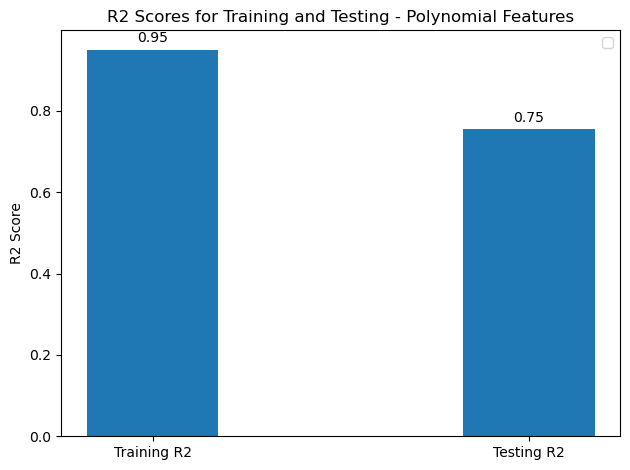

''

In [97]:
# R2 score for train and test
train_r2 = ols.score(Z_train, y_train)
test_r2 = ols.score(Z_test, y_test)

# Plotting
labels = ['Training R2', 'Testing R2']
scores = [train_r2, test_r2]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x, scores, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('R2 Score')
ax.set_title('R2 Scores for Training and Testing - Polynomial Features')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Autolabel function to show the scores on the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()
plt.savefig('r2_scores_polynomial.png')
plt.show()
;

In [82]:
ols.intercept_

177808.20840269842

## RidgeCV

In [83]:
# Instatiate
ridge_model = Ridge(alpha=10)

# Set up a list of ridge alphas to check
r_alphas = np.logspace(0, 5, 100)

# Cross-validate over our list of ridge alphas
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=10)

# Fit model using best ridge alpha
ridge_cv = ridge_model.fit(Z_train, y_train)

In [84]:
# Optimal value of alpha
ridge_cv.alpha

10

In [85]:
print(f'Train ridge R2 score: {ridge_cv.score(Z_train, y_train)}')
print(f'Test ridge R2 score: {ridge_cv.score(Z_test, y_test)}')

Train ridge R2 score: 0.9187902388378487
Test ridge R2 score: 0.8902818175621022


- Train R2 score explains ~92% of the variance in the sale price
- Test R2 score explains ~89% of the variance in the sale price
- Ridge Regression Model is not overfitting and is robust and reliable in making predictions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


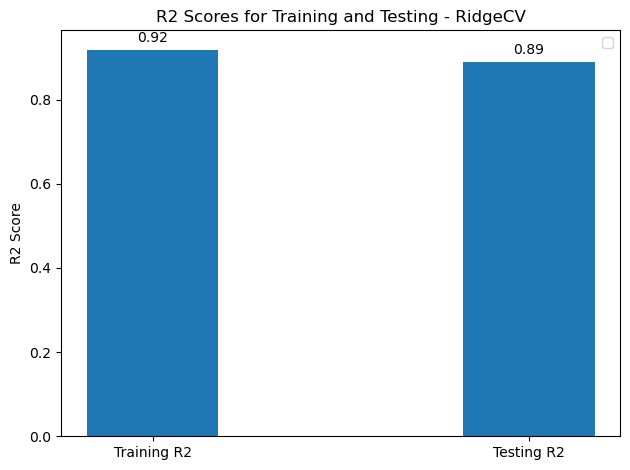

''

In [96]:
# R2 score for train and test
train_r2 = ridge_cv.score(Z_train, y_train)
test_r2 = ridge_cv.score(Z_test, y_test)

# Plotting
labels = ['Training R2', 'Testing R2']
scores = [train_r2, test_r2]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x, scores, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('R2 Score')
ax.set_title('R2 Scores for Training and Testing - RidgeCV')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Autolabel function to show the scores on the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()
plt.savefig('r2_scores_ridgecv.png')
plt.show()
;

In [87]:
ridge_cv.intercept_

177808.20846905533

## LassoCV

In [90]:
# Set up a list of lasso alphas to check
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of lass alphas
lasso_cv = LassoCV(alphas=l_alphas, cv=10, max_iter=50_000)

# Fit model using best ridge alpha
lasso_cv.fit(Z_train, y_train)

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]),
        cv=10, max_iter=50000)

In [91]:
# Optimal value of alpha
lasso_cv.alpha_

1.0

In [92]:
print(f'Train lasso R2 score: {lasso_cv.score(Z_train, y_train)}')
print(f'Test lasso R2 score: {lasso_cv.score(Z_test, y_test)}')

Train lasso R2 score: 0.9403075777337763
Test lasso R2 score: 0.8305771481815205


- Train R2 score explains ~84% of the variance in the sale price
- Test R2 score explains ~83% of the variance in the sale price
- Lasso Regression Model is not overfitting and is robust and reliable in making predictions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


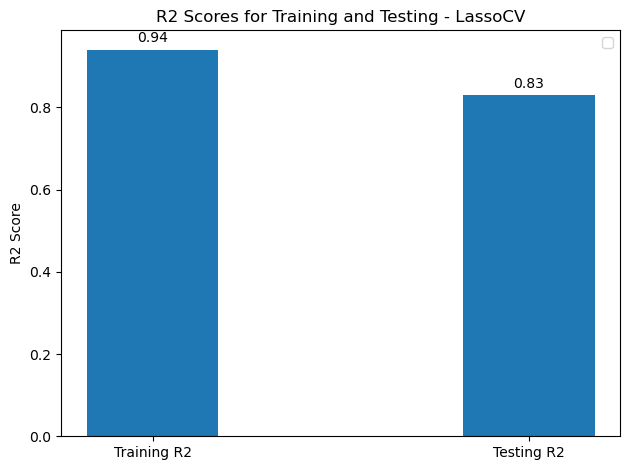

''

In [95]:
# R2 score for train and test
train_r2 = lasso_cv.score(Z_train, y_train)
test_r2 = lasso_cv.score(Z_test, y_test)

# Plotting
labels = ['Training R2', 'Testing R2']
scores = [train_r2, test_r2]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x, scores, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('R2 Score')
ax.set_title('R2 Scores for Training and Testing - LassoCV')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Autolabel function to show the scores on the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()
plt.savefig('r2_scores_lassocv.png')
plt.show()
;

In [94]:
lasso_cv.intercept_

177808.20846905644

# Visualizations

In [135]:
train_no_dummy = pd.read_csv('../clean_datasets/finish_clean_training.csv')

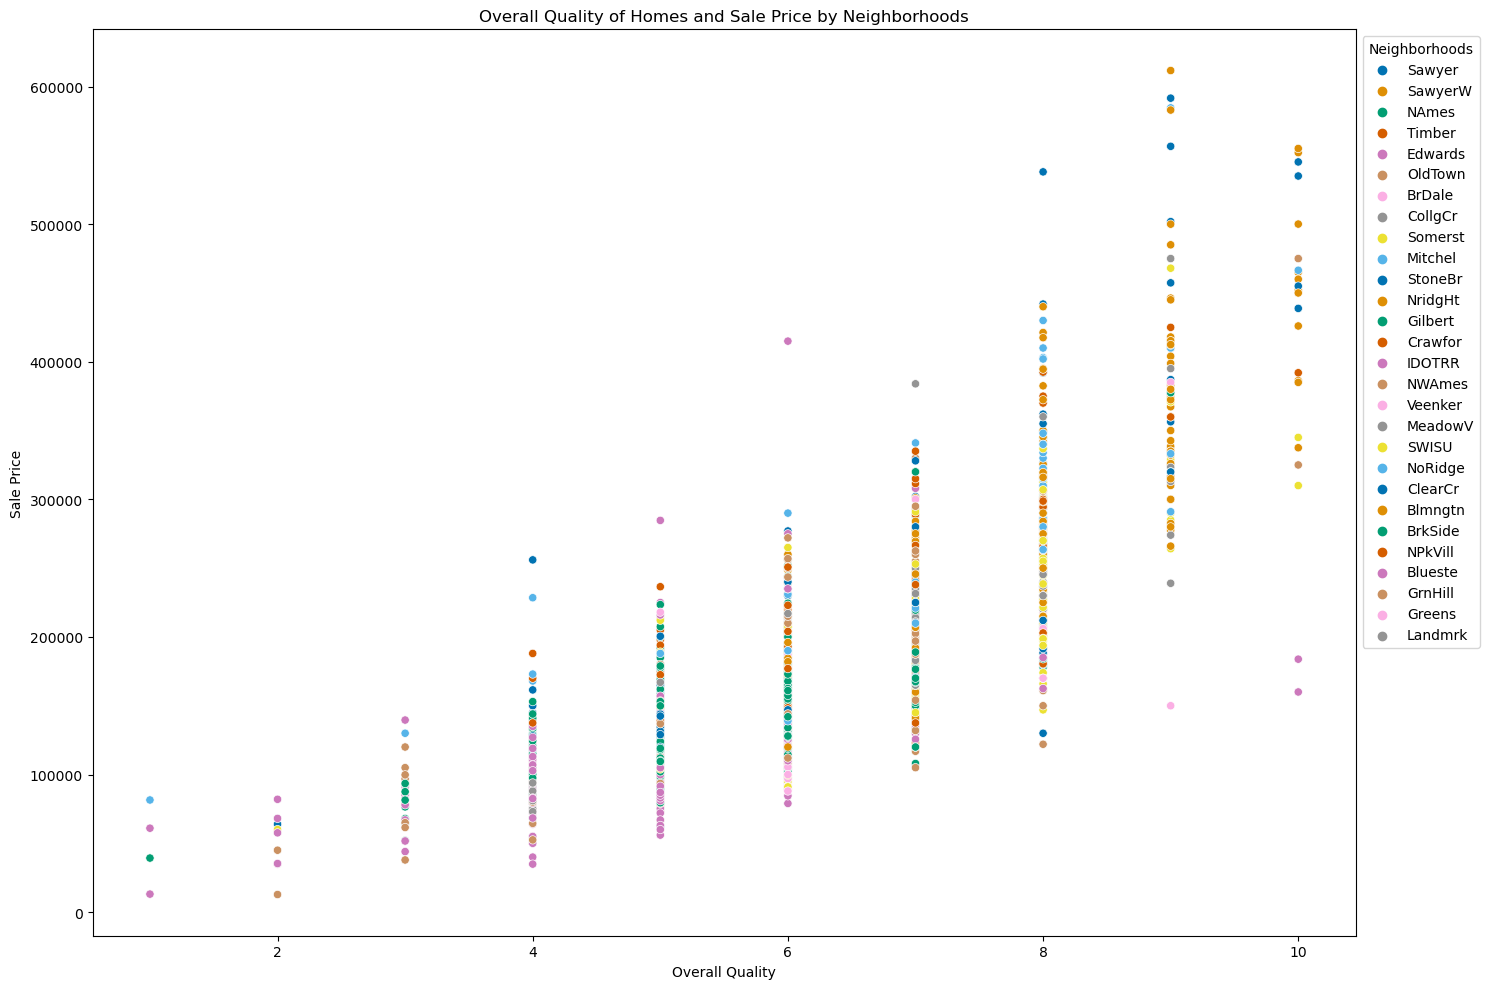

In [138]:
# Scatterplot - Overall Quality x Sale Price x Neighborhood
plt.figure(figsize=(15,10))
# Plot
sns.scatterplot(x='overall_qual', y='saleprice', hue='neighborhood', data=train_no_dummy, palette='colorblind')
# Title
plt.title('Overall Quality of Homes and Sale Price by Neighborhoods')
# Set X and Y
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
#Legend
plt.legend(title='Neighborhoods', bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout();

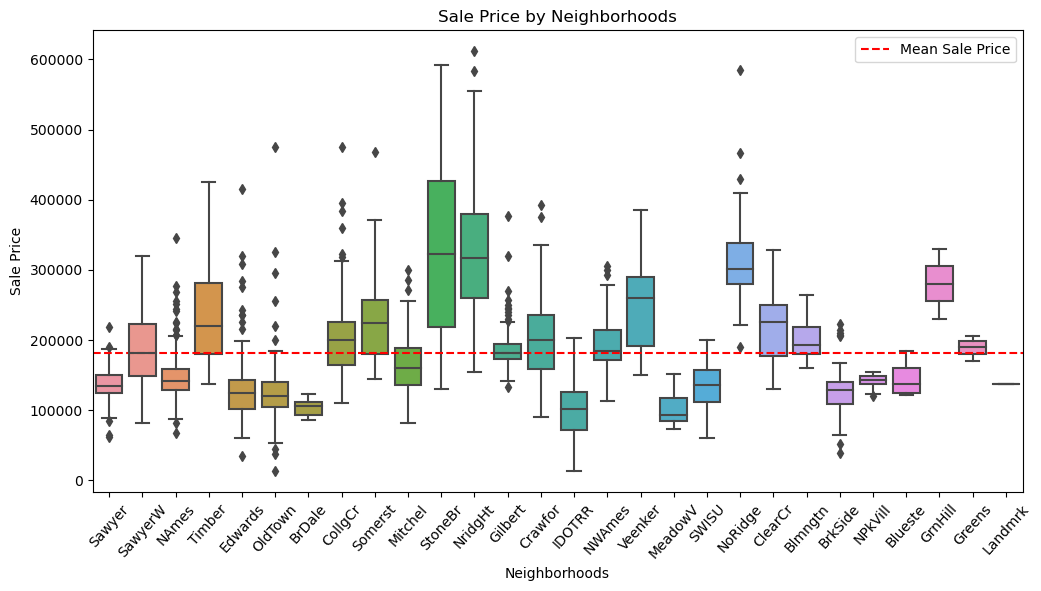

In [161]:
# Boxplot - Neighborhood x Sale Price
plt.figure(figsize=(12,6))
sns.boxplot(x='neighborhood', y='saleprice', data=train_no_dummy)
# Descriptive title for first plot
plt.title('Sale Price by Neighborhoods')
# X and Y labels for first plot
plt.xlabel('Neighborhoods')
plt.ylabel('Sale Price')
plt.xticks(rotation=48)

# Calculate the mean sale price
mean_sale_price = train_no_dummy['saleprice'].mean()
plt.axhline(mean_sale_price, color='red', linestyle='--', label='Mean Sale Price')
plt.legend()
plt.savefig('sale_neighborhood.png');

> Included the mean sale price which is around $181,146

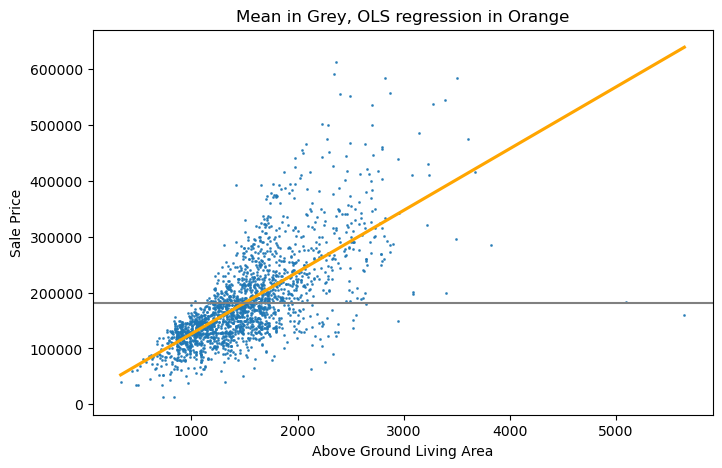

In [148]:
# Regplot - Above Ground Living Area x Sale Price
plt.figure(figsize=(8,5))
sns.regplot(x='gr_liv_area', y='saleprice', data=train_no_dummy, ci=None,
           scatter_kws={'s': 1},
           line_kws={'color': 'orange'})
plt.axhline(train_no_dummy['saleprice'].mean(), color='grey')
plt.xlabel('Above Ground Living Area')
plt.ylabel('Sale Price')
plt.title('Mean in Grey, OLS regression in Orange');

> Positive OLS regression for gr_liv_area and saleprice

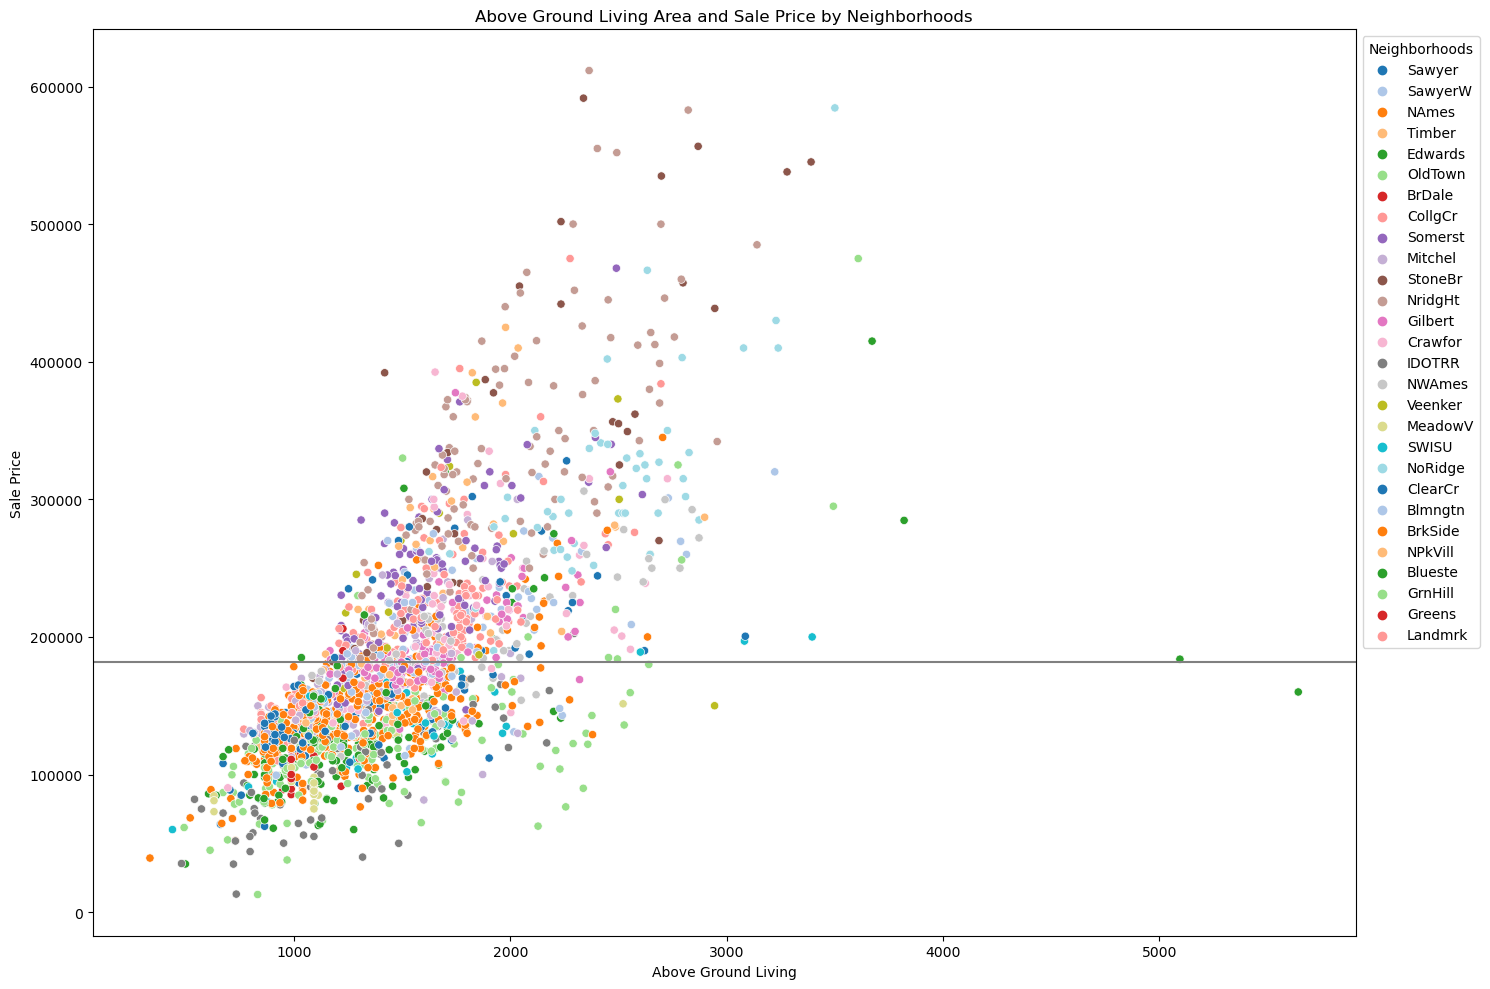

In [160]:
# Scatter - Above Ground Living Area x Sale Price x Neighborhood
plt.figure(figsize=(15,10))
# Define a custom color palette with enough unique colors
custom_palette = sns.color_palette('tab20', n_colors=len(train_no_dummy['neighborhood'].unique()))
# Plot
sns.scatterplot(x='gr_liv_area', y='saleprice', hue='neighborhood', data=train_no_dummy, palette=custom_palette)
# Title
plt.title('Above Ground Living Area and Sale Price by Neighborhoods')
# Set X and Y
plt.xlabel('Above Ground Living')
plt.ylabel('Sale Price')
plt.axhline(train_no_dummy['saleprice'].mean(), color='grey')
#Legend
plt.legend(title='Neighborhoods', bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout()
plt.savefig('gr_liv_area_sale_neighborhood.png');

> Many of the neighborhoods are < 3,000 above ground and fall around 1000-2000

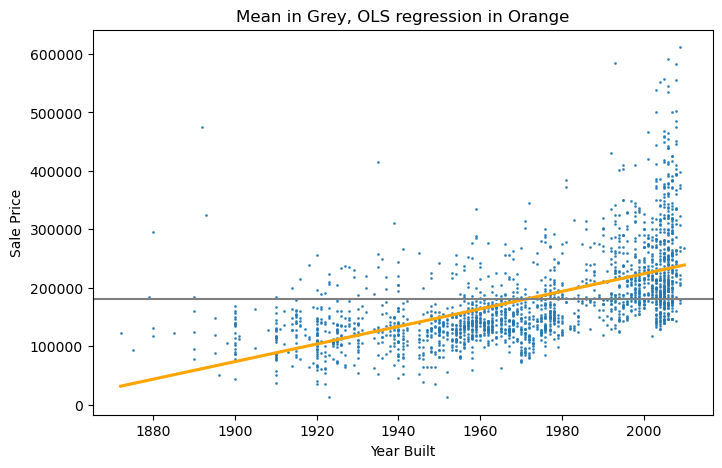

In [150]:
# Regplot - Year Built x Sale Price
plt.figure(figsize=(8,5))
sns.regplot(x='year_built', y='saleprice', data=train_no_dummy, ci=None,
           scatter_kws={'s': 1},
           line_kws={'color': 'orange'})
plt.axhline(train_no_dummy['saleprice'].mean(), color='grey')
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.title('Mean in Grey, OLS regression in Orange');

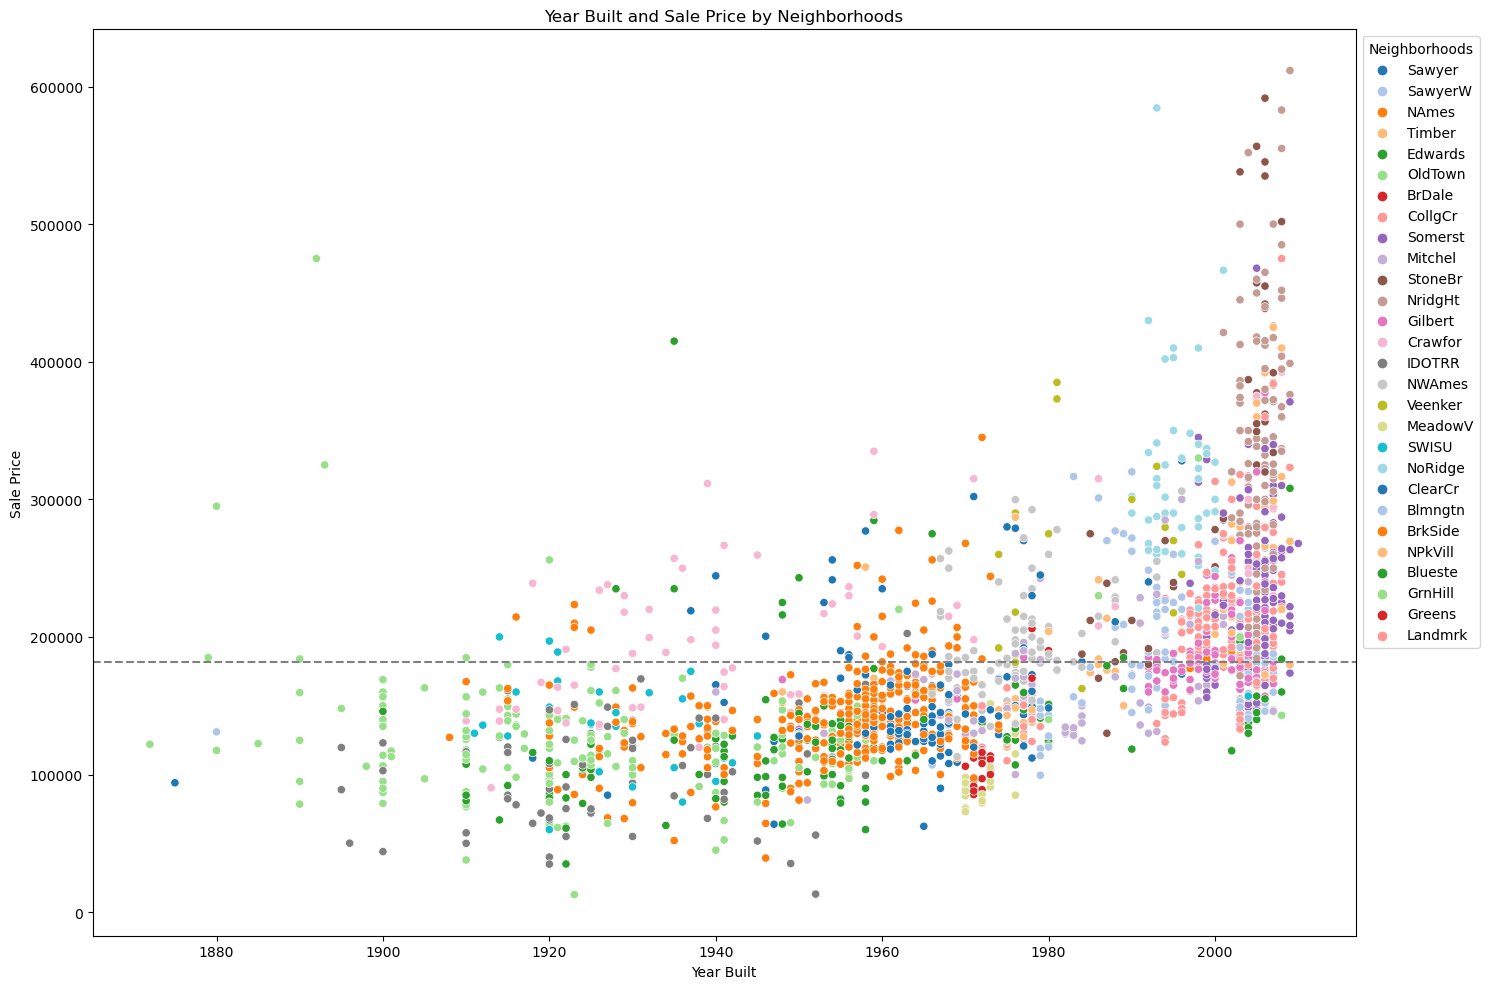

In [159]:
# Scatter - Year Built x Sale Price x Neighborhood
plt.figure(figsize=(15,10))
# Define a custom color palette with enough unique colors
custom_palette = sns.color_palette('tab20', n_colors=len(train_no_dummy['neighborhood'].unique()))
# Plot
sns.scatterplot(x='year_built', y='saleprice', hue='neighborhood', data=train_no_dummy, palette=custom_palette)
# Title
plt.title('Year Built and Sale Price by Neighborhoods')
# Set X and Y
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.axhline(train_no_dummy['saleprice'].mean(), color='grey', linestyle='--')
#Legend
plt.legend(title='Neighborhoods', bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout()
plt.savefig('yearbuilt_sale_neighborhood.png');

> Somerset (purple), Stone Brooke (Dark Brown), Northridge height (Light brown), are generally more expensive and are on the north side of ames (developing)

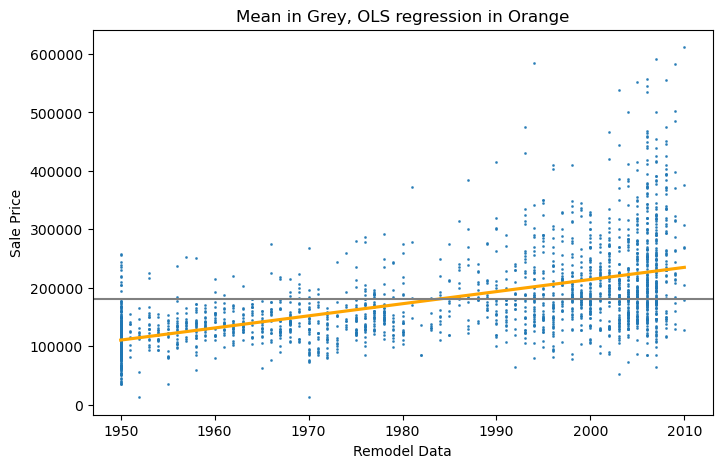

In [152]:
# Regplot - Remodel Date x Sale Price
plt.figure(figsize=(8,5))
sns.regplot(x='year_remod/add', y='saleprice', data=train_no_dummy, ci=None,
           scatter_kws={'s': 1},
           line_kws={'color': 'orange'})
plt.axhline(train_no_dummy['saleprice'].mean(), color='grey')
plt.xlabel('Remodel Date')
plt.ylabel('Sale Price')
plt.title('Mean in Grey, OLS regression in Orange');

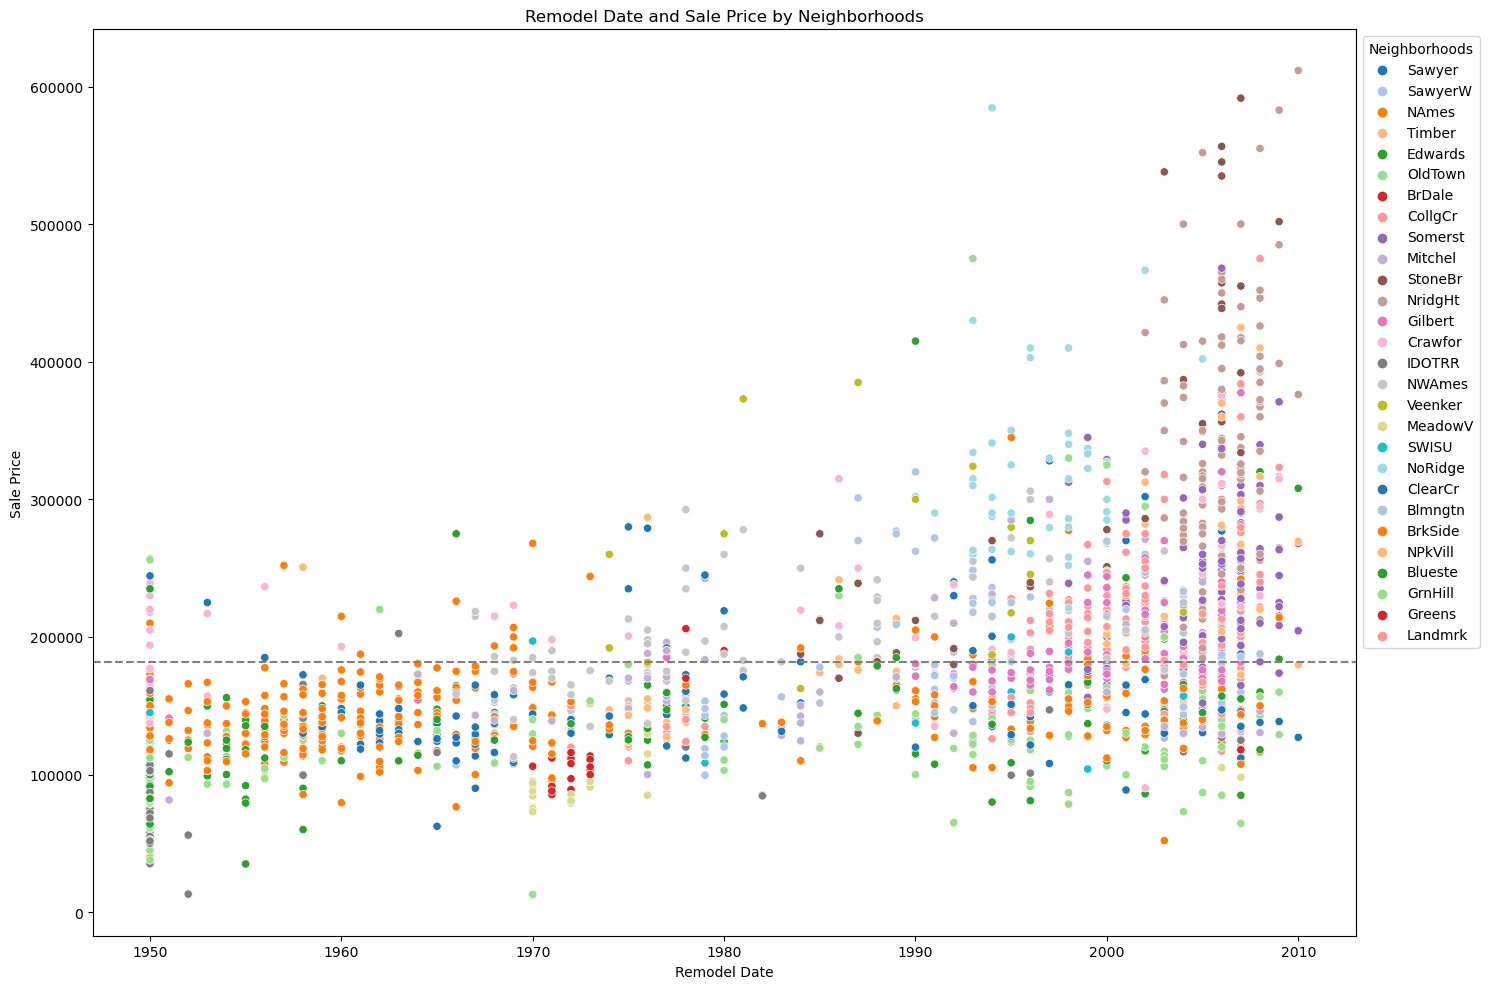

In [158]:
# Scatter - Remodel Date x Sale Price x Neighborhood
plt.figure(figsize=(15,10))
# Define a custom color palette with enough unique colors
custom_palette = sns.color_palette('tab20', n_colors=len(train_no_dummy['neighborhood'].unique()))
# Plot
sns.scatterplot(x='year_remod/add', y='saleprice', hue='neighborhood', data=train_no_dummy, palette=custom_palette)
# Title
plt.title('Remodel Date and Sale Price by Neighborhoods')
# Set X and Y
plt.xlabel('Remodel Date')
plt.ylabel('Sale Price')
plt.axhline(train_no_dummy['saleprice'].mean(), color='grey', linestyle='--')
#Legend
plt.legend(title='Neighborhoods', bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout()
plt.savefig('remodel_sale_neighborhood.png');

> As newer houses get remodeled and built (north of ames), price increases